In [1]:
from collections import namedtuple
import glob
from itertools import islice
from operator import lt, gt

from astropy.coordinates import Angle, SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import corner
from ebltable.tau_from_model import OptDepth
import emcee
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 18, 'figure.figsize': (14.0, 8.0)})
from numba import njit
import numpy as np
import pandas as pd
from scipy import integrate, interpolate, optimize, stats

In [2]:
# Read in the source selection catalog
whsp = pd.read_csv("2WHSP_catalog.txt", skiprows=4, delimiter=' *\| *', engine='python', na_filter=False)
# Drop dummy columns caused by extra delimiters
whsp.drop(whsp.columns[[0, -1]], axis=1, inplace=True)
# Munge flags into Boolean values
for col in whsp.columns:
    if col.endswith('_flag'):
        whsp[col].replace({':': True, '': False}, inplace=True)
    elif col.endswith('_limit'):
        whsp[col].replace({'&gt;': True, '': False}, inplace=True)
# Convert sexagesimal coordinates to decimal degrees
whsp['ra'] = Angle(whsp['ra'], unit='hourangle').to_value(u.degree)
whsp['dec'] = Angle(whsp['dec'], unit='deg').value
whsp

,name,ra,dec,lii,bii,source_flag,bzcat_object_type,log_nu_peak_limit,log_nu_peak,log_nu_peak_flag,...,log_nu_f_nu_flag,redshift_limit,redshift,redshift_flag,ref_redshift,fermi_lat_detection,gamma_ray_index,gamma_ray_index_error,twofhl_name,figure_of_merit
0,2WHSP J045823.5-864408,74.597917,-86.735556,299.6559,-28.6358,False,,False,16.0,True,...,True,False,,False,,,,,,0.10
1,2WHSP J211011.1-861847,317.546250,-86.313056,306.4041,-29.1836,False,,False,15.4,False,...,False,False,,False,,3FGL J2108.6-8619,1.74,0.26,2FHL J2112.5-861,0.20
2,2WHSP J153103.7-861225,232.765417,-86.206944,305.5986,-24.1936,False,,False,15.6,False,...,False,False,,False,,,,,,0.32
3,2WHSP J102634.3-854314,156.642917,-85.720556,300.1731,-23.6490,False,5BZB,False,15.0,False,...,False,False,,False,,3FGL J1026.4-8542,2.01,0.08,2FHL J1026.9-854,0.63
4,2WHSP J222610.9-840621,336.545417,-84.105833,307.0361,-31.8176,False,,False,16.1,False,...,False,False,,False,,,,,,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,2WHSP J041949.3+843835,64.955417,84.643056,127.5486,23.7625,False,,False,16.2,False,...,False,False,,False,,,,,,0.10
1687,2WHSP J214609.6+850148,326.540000,85.030000,119.0102,23.6419,False,,False,15.7,False,...,False,False,,False,,,,,,0.25
1688,2WHSP J074716.2+851207,116.817500,85.201944,128.2161,28.1864,False,,False,16.8,False,...,False,False,,False,,3FGL J0746.9+8511,1.79,0.12,,0.25
1689,2WHSP J104810.9+855957,162.045417,85.999167,125.3103,30.5442,False,,False,17.0,True,...,True,False,,False,,,,,,0.16


In [3]:
# Define sky selection cuts
def sky_selection_cuts(ra, dec, ra_bounds=None, dec_bounds=None, b_bounds=None):
    """Applies selection cuts on sky coordinates
    
    RA, Dec, and bounds should be specified in degrees.
    Bounds should be expressed as lists of bounds tuples:
        [(lower_bound_1, upper_bound_1), (lower_bound_2, upper_bound_2)...]
    """
    cut_mask = np.ones(len(ra), dtype=bool)
    print("{} sources total".format(len(cut_mask)))
    if ra_bounds:
        ra_mask = np.zeros(len(cut_mask[cut_mask]), dtype=bool)
        for lower, upper in ra_bounds:
            ra_mask |= (lower <= ra[cut_mask]) & (ra[cut_mask] <= upper)
        cut_mask[cut_mask] &= ra_mask
        print("{} sources left after RA cut".format(sum(cut_mask)))
    if dec_bounds:
        dec_mask = np.zeros(len(cut_mask[cut_mask]), dtype=bool)
        for lower, upper in dec_bounds:
            dec_mask |= (lower <= dec[cut_mask]) & (dec[cut_mask] <= upper)
        cut_mask[cut_mask] &= dec_mask
        print("{} sources left after declination cut".format(sum(cut_mask)))
    if b_bounds:
        b = SkyCoord(ra=ra[cut_mask], dec=dec[cut_mask], unit='deg').galactic.b.value
        b_mask = np.zeros(len(cut_mask[cut_mask]), dtype=bool)
        for lower, upper in b_bounds:
            b_mask |= (lower < b) & (b < upper)
        cut_mask[cut_mask] &= b_mask
        print("{} sources left after Galactic latitude cut".format(sum(cut_mask)))
    return cut_mask

In [4]:
# Apply selection cuts to 2WHSP catalog
#ra_bounds = [((6*u.hourangle).to_value(u.degree), (10*u.hourangle).to_value(u.degree))]
ra_bounds = [((0*u.hourangle).to_value(u.degree), (24*u.hourangle).to_value(u.degree))]
dec_bounds = [(1.7, 61.7)]
b_bounds = [(-np.inf, -10), (10, np.inf)]

cut_mask = sky_selection_cuts(whsp.ra, whsp.dec, ra_bounds=ra_bounds, dec_bounds=dec_bounds, b_bounds=b_bounds)
cut_mask[cut_mask] = whsp.figure_of_merit[cut_mask] > 1
print("{} sources left after Figure of Merit cut".format(sum(cut_mask)))

1691 sources total
1691 sources left after RA cut
787 sources left after declination cut
776 sources left after Galactic latitude cut
40 sources left after Figure of Merit cut


In [5]:
# Calculate sky coverage (taking into account sky selection cuts only)
# The effects of the RA and Dec cuts are determined analytically,
# but the effect of the Galactic latitude cut is found using a Monte Carlo method,
# since that coordinate is not orthogonal to the first two

num_points = 1000000
coords = np.random.random([num_points, 2])

ra_lo, ra_hi = ra_bounds[0]
ra_fraction = (ra_hi - ra_lo) / 360
print("Fraction kept after RA cut: {:.04}".format(ra_fraction))
ra = (ra_hi - ra_lo)*coords[:,0] + ra_lo

dec_lo, dec_hi = (np.pi/180)*np.array(dec_bounds[0])
dec_fraction = (np.sin(dec_hi) - np.sin(dec_lo)) / 2
print("Fraction kept after Dec cut: {:.04}".format(dec_fraction))
dec = 180/np.pi*np.arcsin(2*np.sin((dec_hi - dec_lo)/2)*np.cos((dec_hi + dec_lo)/2)*coords[:,1] + np.sin(dec_lo))

b_fraction = sum(sky_selection_cuts(ra, dec, b_bounds=b_bounds)) / num_points
print("Fraction kept after Galactic latitude cut: {:.04}".format(b_fraction))

sky_coverage_const = ra_fraction * dec_fraction * b_fraction
print("Sky coverage: {:.04}".format(sky_coverage_const))

Fraction kept after RA cut: 1.0
Fraction kept after Dec cut: 0.4254
1000000 sources total
820822 sources left after Galactic latitude cut
Fraction kept after Galactic latitude cut: 0.8208
Sky coverage: 0.3492


In [6]:
# Since we required 2WHSP FoM > 1 (as opposed to >= 1),
# determine the synchrotron flux limit using the flux of the weakest possibly detected source
# Don't take into account the other cuts, since the cuts are independent

min_log_nu_f_nu = np.min(whsp.log_nu_f_nu[whsp.figure_of_merit > 1].to_numpy())
min_nu_f_nu = (10**min_log_nu_f_nu)*u.erg/(u.cm*u.cm)/u.s
print("Minimum log(nu F_nu) is {}, giving {:.04}".format(min_log_nu_f_nu, min_nu_f_nu))

Minimum log(nu F_nu) is -12.2, giving 6.31e-13 erg / (cm2 s)


In [7]:
def logN_logS(fluxes, sky_coverage_const=1.0, label=None):
    nums = np.array(range(len(fluxes), 0, -1)) / sky_coverage_const / (4*np.pi*u.sr).to_value(u.degree*u.degree)
    plt.plot(np.sort(fluxes), nums, label=label)
    plt.xscale('log')
    plt.xlabel("S [erg cm^-2 s^-1]")
    plt.yscale('log')
    plt.ylabel("N(>S) [deg^-2]")
    plt.legend()

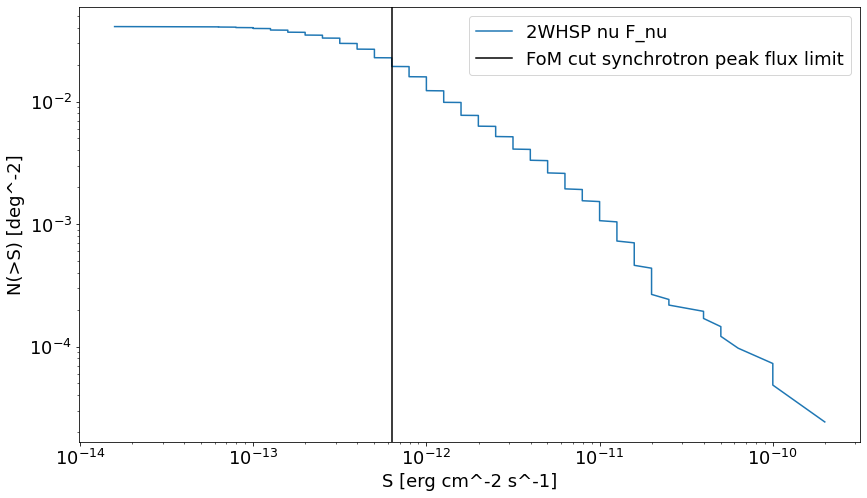

In [8]:
# Plot the logN-logS of the 2WHSP sources, to show that the slope is constant in the selection region
logN_logS(10**whsp.log_nu_f_nu, label="2WHSP nu F_nu")
plt.axvline(min_nu_f_nu.value, color='k', label="FoM cut synchrotron peak flux limit")
plt.legend()

In [9]:
# Read in our data and join in to the selected 2WHSP sources
vts_data = pd.read_csv("LF_blazar_data.csv")
data = vts_data.join(whsp[cut_mask].set_index('name'), on='whsp_name', how='inner')

# Olivier calculated an average Mrk 501 flux of 23% Crab (it's listed as "variable" in TeVCat)
data.loc[data.source == "Mkn 501", 'tevcat_flux_crab'] = 0.23

data

,source,whsp_name,z,archival_hours,year1_hours,legacy_hours,tevcat_flux_crab,tevcat_index,ra,dec,...,log_nu_f_nu_flag,redshift_limit,redshift,redshift_flag,ref_redshift,fermi_lat_detection,gamma_ray_index,gamma_ray_index_error,twofhl_name,figure_of_merit
0,RGB J0152+017,2WHSP J015239.5+014717,0.080,19.3,0.0,5,0.020,2.95,28.164583,1.788056,...,False,False,0.080,False,,3FGL J0152.6+0148,1.89,0.10,2FHL J0152.8+014,1.26
1,B3 0133+388,2WHSP J013632.5+390558,NaN,18.5,0.0,5,NaN,NaN,24.135417,39.099444,...,False,False,,False,,3FGL J0136.5+3905,1.70,0.02,2FHL J0136.5+390,2.51
2,1ES 0120+340,2WHSP J012308.5+342048,0.270,11.1,5.0,8,NaN,NaN,20.785417,34.346667,...,False,False,0.270,False,,3FGL J0122.8+3423,1.48,0.14,,3.16
3,RGB J0045+214,2WHSP J004519.2+212739,NaN,0.9,3.5,10,NaN,NaN,11.330000,21.460833,...,False,False,,False,,3FGL J0045.3+2126,1.90,0.05,2FHL J0045.2+212,1.26
4,1ES 0229+200,2WHSP J023248.5+201717,0.139,198.6,18.0,0,0.018,2.50,38.202083,20.288056,...,False,False,0.139,False,,3FGL J0232.8+2016,2.03,0.14,,2.00
5,RGB J0321+236,2WHSP J032159.8+233611,NaN,10.6,4.0,8,NaN,NaN,50.499167,23.603056,...,False,False,,False,,3FGL J0322.0+2335,1.95,0.07,2FHL J0322.0+233,1.26
6,1FGL J0333.7+2919,2WHSP J033349.0+291631,NaN,3.3,7.9,10,NaN,NaN,53.454167,29.275278,...,False,False,,False,,3FGL J0333.6+2916,1.86,0.06,2FHL J0333.7+291,1.26
7,RGB J0316+090,2WHSP J031612.7+090442,NaN,5.7,6.0,10,NaN,NaN,49.052917,9.078333,...,False,False,,False,,3FGL J0316.1+0904,1.92,0.04,2FHL J0316.1+090,2.00
8,GB6 J0540+5823,2WHSP J054029.9+582338,NaN,2.8,8.7,16,NaN,NaN,85.124583,58.393889,...,False,False,,False,,3FGL J0540.4+5823,2.00,0.08,2FHL J0540.5+582,1.58
9,RGB J0710+591,2WHSP J071029.9+590820,0.120,166.2,0.0,0,0.030,2.69,107.624583,59.138889,...,False,False,0.120,False,,3FGL J0710.3+5908,1.66,0.09,2FHL J0710.5+590,3.98


In [10]:
# RGB J2243+203 should have been included in our LF selection (FOM = 1.58)
# 1ES 2344+514 should have been excluded from our LF selection (galactic latitude = -9.9)

print("Should have included: {}".format(",".join(list(set(whsp.name[cut_mask]) - set(vts_data.whsp_name)))))
print("Should have excluded: {}".format(",".join(list(set(vts_data.whsp_name) - set(whsp.name[cut_mask])))))

Should have included: 2WHSP J224354.7+202102
Should have excluded: 2WHSP J234704.7+514216


In [11]:
def crab_flux_to_photon_flux(crab_flux, threshold_energy):
    crab_index= 2.49
    crab_norm = 3.2e-11/(u.cm*u.cm)/u.s/u.TeV
    crab_E0 = 1.0 * u.TeV
    crab_photon_flux = (crab_norm * crab_E0 / (crab_index - 1)
                        * np.power(threshold_energy.to(u.TeV)/crab_E0, 1 - crab_index))
    return crab_flux * crab_photon_flux

def get_spectrum(flux, index, e_min, e_max, num_bins=60, e_0=1.*u.TeV, e_start=0.03*u.TeV, e_stop=30.*u.TeV):
    """Return the binned fluxes corresponding to the power law spectrum, given the spectral parameters
    
    Arguments:
        flux: Quantity, total flux of the source
        index: array, photon spectral index
        e_min: Quantity [energy], energy threshold of the spectrum
        e_max: Quantity [energy], maximum energy of the spectrum
        e_0: Quantity [energy], scale energy of the spectrum
        e_start: Quantity [energy], smallest energy to return
        e_stop: Quantity [energy], largest energy to return
        num_bins: int, number of flux bins to include in the spectrum
    
    Returns:
        spectrum: Quantity [flux.unit], binned fluxes from e_start to e_stop
        bin_edges: Quantity [TeV], sequence of length num_bins + 1 defining the bin energies
    """
    
    # Approxmate the spectrum as a sequence of energy bins
    # determined by the provided spectral parameters and integrated flux
    norm = flux * (index - 1) / e_0 / ((e_min/e_0)**(1 - index) - (e_max/e_0)**(1 - index))
    norm = np.expand_dims(norm, axis=1)
    bin_edges = np.geomspace(e_start.to_value(u.TeV), e_stop.to_value(u.TeV), num=(num_bins + 1))*u.TeV
    # The bin geometric center (ignoring the spectral index) is a good approximation for the bin average energy
    # in the limit of many small logarithmically spaced bins
    bin_ctrs = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    spectrum = (norm.to(1/(u.cm**2)/u.s/u.TeV) * bin_widths
                * np.power(bin_ctrs/e_0, -np.expand_dims(index, axis=1)))
    
    def beyond_bound(energy, op):
        return op(bin_ctrs.to_value(u.TeV), np.reshape(energy, (-1, 1)).to_value(u.TeV))
    
    spectrum[beyond_bound(e_min, lt) | beyond_bound(e_max, gt)] = 0

    return spectrum.to(flux.unit), bin_edges


tau = OptDepth.readmodel(model='dominguez')

def deabsorb_spectrum(spectrum, bin_edges, z):
    bin_ctrs = np.sqrt(bin_edges[:-1] * bin_edges[1:]).to_value(u.TeV)
    return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))


def spectrum_to_eflux(spectrum, bin_edges, z, deabsorb=False):
    deabs_spectrum = deabsorb_spectrum(spectrum, bin_edges, z) if deabsorb else spectrum
    bin_ctrs = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    eflux = np.sum(deabs_spectrum * bin_ctrs, axis=1)
    return eflux


cosmo = FlatLambdaCDM(H0=70*(u.km/u.s/u.Mpc), Tcmb0=2.725*u.K, Om0=0.3)

def luminosity_to_eflux(luminosity, index, z):
    """Convert the luminosity to energy flux
    
    Account for cosmological expansion (assuming a standard flat Lambda CDM universe)
    in calculating the luminosity distance and applying the K-correction for a power law spectrum.
    """
    eflux = luminosity / (4*np.pi * cosmo.luminosity_distance(z).to(u.cm)**2 * np.power(1 + z, index - 1))
    return eflux.to(u.erg/(u.cm*u.cm)/u.s)


def eflux_to_luminosity(eflux, index, z):
    """Convert the energy flux to luminosity
    
    Account for cosmological expansion (assuming a standard flat Lambda CDM universe)
    in calculating the luminosity distance and applying the K-correction for a power law spectrum.
    """
    luminosity = 4*np.pi * eflux * cosmo.luminosity_distance(z).to(u.cm)**2 * np.power(1 + z, index - 1)
    return luminosity.to(u.erg/u.s)


def spectrum_to_luminosity(spectrum, bin_edges, index, z, deabsorb=False):
    eflux = spectrum_to_eflux(spectrum, bin_edges, z, deabsorb=deabsorb)
    luminosity = eflux_to_luminosity(eflux, index, z)
    return luminosity

In [12]:
# Define constant assumed values for the analysis

# The SED is flat at the synchrotron peak -> spectral index = 1
synchrotron_peak_index = 1

# Since we're using fluxes from TeVCat, we don't have the actual spectra
e_min = 0.3*u.TeV
e_start = 0.03*u.TeV
e_stop = 30.*u.TeV
num_bins = 60  # Number of spectral bins (20 per decade)


def process_veritas_data(data):
    """Process raw VERITAS data into a dataframe suitable for plotting distributions"""
    
    df = pd.DataFrame()
    units = {}
    labels = {}
    
    inputs = {
        # Use a default flux in Crab units for sources without one in TeVCat
        'flux': (crab_flux_to_photon_flux(np.nan_to_num(data.tevcat_flux_crab.to_numpy(), nan=0.01), e_min),
                 1/u.cm**2/u.s, "TeV Flux\n[ph cm^-2 s^-1]"),
        'whsp_flux': (10**data.log_nu_f_nu.to_numpy(), u.erg/(u.cm**2)/u.s, "Synchrotron Flux\n[erg cm^-2 s^-1]"),
        # Use a default spectral index for sources without one in TeVCat
        'index': (np.nan_to_num(data.tevcat_index.to_numpy(), nan=3.5), u.dimensionless_unscaled,
                  "Spectral Index"),
        # Use a default redshift for sources without a known redshift
        'z': (np.nan_to_num(data.z.to_numpy(), nan=0.5), u.dimensionless_unscaled, "Redshift"),
        #'exposure': ((data.archival_hours + data.year1_hours).to_numpy(), u.hr, "Exposure\n[hr]"),
        'exposure': ((data.archival_hours + data.legacy_hours).to_numpy(), u.hr, "Exposure\n[hr]"),
        'fom': (data.figure_of_merit.to_numpy(), u.dimensionless_unscaled, "2WHSP Figure of Merit"),
    }

    for key in inputs:
        df[key], units[key], labels[key] = inputs[key]
    
    return df, units, labels


def calculate_luminosity(processed_data, processed_units, processed_labels):
    """Calculate the luminosity and related quantities using the processed data"""
    
    def value(key):
        return processed_data[key].to_numpy() * processed_units[key]
    
    df = pd.DataFrame()
    units = {}
    labels = {}
    
    spectrum, bin_edges = get_spectrum(value('flux'), value('index'), e_min=e_min, e_max=e_max,
                                       e_start=e_start, e_stop=e_stop, num_bins=num_bins)
    
    outputs = {
        'whsp_luminosity': (eflux_to_luminosity(value('whsp_flux'), synchrotron_peak_index, value('z')),
                            "Synchrotron Luminosity\n[erg s^-1]"),
        'tev_eflux': (spectrum_to_eflux(spectrum, bin_edges, value('z'), deabsorb=False),
                      "TeV Energy Flux\n[erg cm^-2 s^-1]"),
        'obs_luminosity': (spectrum_to_luminosity(spectrum, bin_edges, value('index'), value('z'),
                                                      deabsorb=False),
                               "TeV Observed Luminosity\n[erg s^-1]"),
        'deabs_luminosity': (spectrum_to_luminosity(spectrum, bin_edges, value('index'), value('z'),
                                                        deabsorb=True),
                                 "TeV Deabsorbed Luminosity\n[erg s^-1]")
    }
    
    for key in outputs:
        df[key], labels[key] = outputs[key]
        units[key] = outputs[key][0].unit
    
    return df, units, labels

Min/max obs_luminosity: 1.769e+43 erg / s, 2.592e+46 erg / s
Min/max deabs_luminosity: 2.512e+43 erg / s, 1.104e+48 erg / s
Min/max z: 0.03, 0.604
Mean exposure: 60.87 h


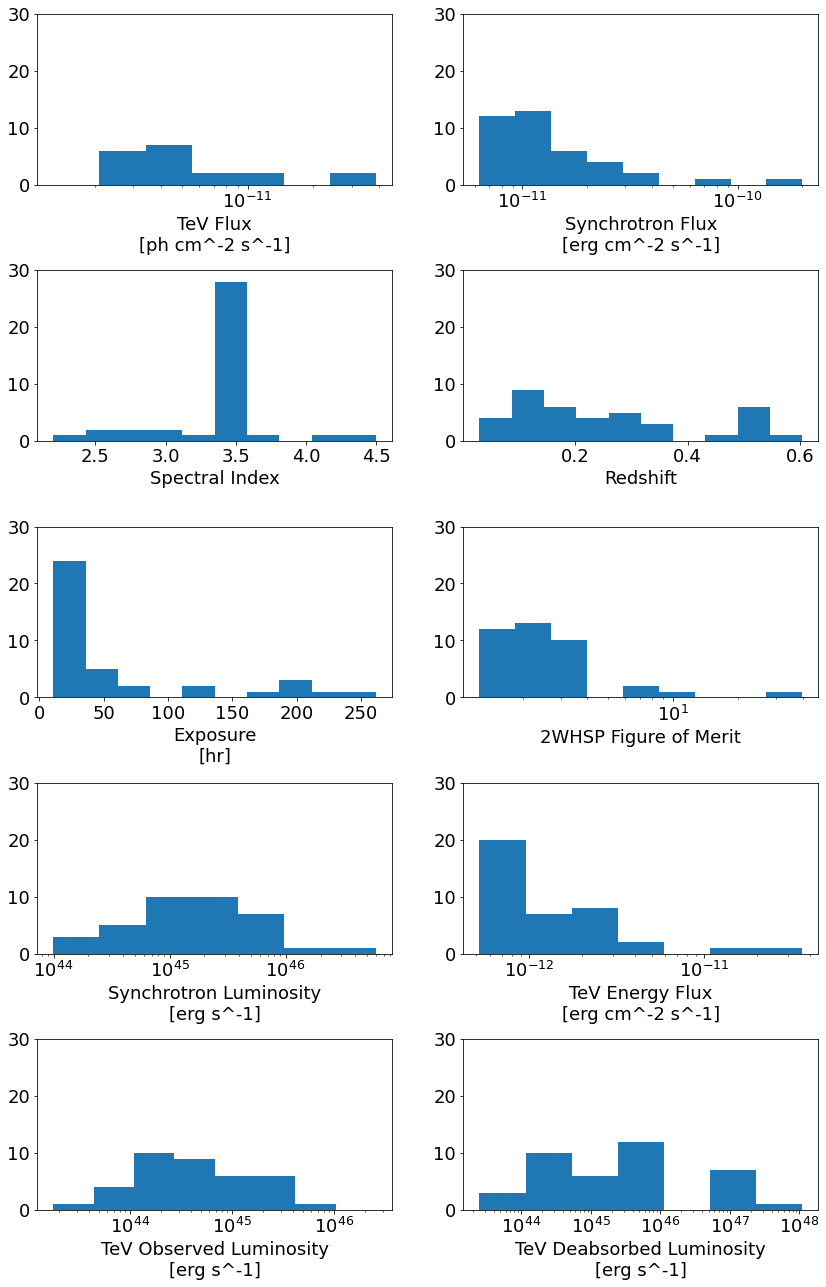

In [13]:
proc_data, proc_units, proc_labels = process_veritas_data(data)
e_max = u.TeV/(3 * proc_data['z'].to_numpy()) # Estimate e_max using as inversely scaled with redshift
lum_data, lum_units, lum_labels = calculate_luminosity(proc_data, proc_units, proc_labels)

all_data = pd.concat((proc_data, lum_data), axis=1)
all_units, all_labels = {**proc_units, **lum_units}, {**proc_labels, **lum_labels}

def value(key):
    return all_data[key].to_numpy() * all_units[key]

for key in ['obs_luminosity', 'deabs_luminosity', 'z']:
    print("Min/max {}: {:.04}, {:.04}".format(key, np.min(value(key)), np.max(value(key))))
mean_exposure = np.mean(value('exposure'))
print("Mean exposure: {:.04}".format(mean_exposure))

# Plot distributions of the data
fig, axes = plt.subplots(5, 2, figsize=(14.0, 22.0))
for ax, (key, arr), label in zip(axes.ravel(), all_data.iteritems(), all_labels.values()):
    if key in ['index', 'z', 'exposure']:
        bins = 10
    else:
        _, bins = np.histogram(np.log10(arr), bins='auto')
        bins = 10**bins
        ax.set_xscale('log')
    ax.hist(arr, bins=bins)
    ax.set_ylim(0, 30)
    ax.set_xlabel(label)
plt.subplots_adjust(hspace=0.5)

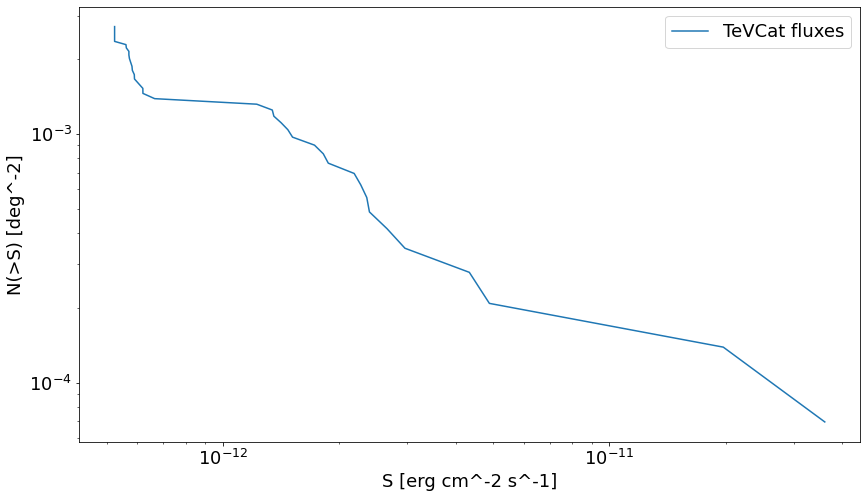

In [14]:
# Plot the logN-logS of the VERITAS sources (using the TeVCat fluxes)
logN_logS(value('tev_eflux'), sky_coverage_const=sky_coverage_const, label="TeVCat fluxes")

In [15]:
def vts_sensitivity_flux(exposure):
    """Returns the flux equivalent to the VERITAS sensitivity at the given exposure.
    
    Uses the VERITAS integral sensitivity calculated by Manel using a VEGAS analysis of 1ES 1218+304:
    https://veritas.sao.arizona.edu/wiki/images/6/6d/Vts_significance_estimate_ME.pdf
    """
    
    sigma = 5
    F_0 = 8.269e-8 * u.m**-2 * u.s**-1
    R_bg = 2.801 * u.min**-1
    R_ex = 0.858 * u.min**-1
    
    flux = sigma*F_0*np.sqrt(R_bg)/R_ex / np.sqrt(exposure)
    return flux.to(u.cm**-2 * u.s**-1)

In [16]:
def limiting_eflux_to_redshift(eflux, luminosity, index):
    num_zs = 250
    zs = np.linspace(0.0, 0.02*num_zs, num_zs)
    efluxes = np.zeros((len(luminosity), num_zs)) * eflux.unit
    for i, z in enumerate(zs):
        efluxes[:, i] = luminosity_to_eflux(luminosity, index, z)
    differences = np.abs(efluxes - np.expand_dims(eflux, axis=1))
    return zs[np.nanargmin(differences, axis=1)].flatten()*u.dimensionless_unscaled


def limiting_spectrum_to_redshift(spectrum, bin_edges, luminosity, index):
    num_zs = 125
    zs = np.linspace(0.0, 0.01*num_zs, num_zs)
    luminosities = np.zeros((len(luminosity), num_zs)) * luminosity.unit
    for i, z in enumerate(zs):
        luminosities[:, i] = spectrum_to_luminosity(spectrum, bin_edges, index, z,
                                                    deabsorb=True).to(luminosity.unit)
    differences = np.abs(luminosities - np.expand_dims(luminosity, axis=1))
    return zs[np.nanargmin(differences, axis=1)].flatten()*u.dimensionless_unscaled

20/39 sources detected
Redshift: [0.08  0.5   0.27  0.5   0.139 0.5   0.5   0.5   0.5   0.12  0.203 0.137
 0.198 0.19  0.278 0.35  0.03  0.2   0.3   0.138 0.143 0.33  0.18  0.13
 0.218 0.135 0.31  0.604 0.443 0.129 0.16  0.24  0.344 0.235 0.03  0.055
 0.18  0.3   0.119]
TeV Limiting Redshift: [0.08064516 0.47379032 0.24193548 0.44354839 0.18145161 0.46370968
 0.45362903 0.45362903 0.46370968 0.17137097 0.24193548 0.16129032
 0.22177419 0.18145161 0.23185484 0.30241935 0.10080645 0.26209677
 0.28225806 0.12096774 0.12096774 0.30241935 0.29233871 0.16129032
 0.25201613 0.2016129  0.29233871 0.64516129 0.54435484 0.18145161
 0.16129032 0.22177419 0.3125     0.2016129  0.10080645 0.07056452
 0.19153226 0.27217742 0.15120968]
2WHSP Limiting Redshift: [0.24096386 1.68674699 1.04417671 1.28514056 0.46184739 1.28514056
 1.28514056 1.54618474 1.40562249 0.54216867 0.80321285 0.562249
 0.54216867 0.68273092 0.88353414 1.10441767 0.42168675 0.86345382
 1.04417671 0.46184739 0.52208835 0.9437751  

/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/ebltable/tau_from_model.py:305: RuntimeWarning: Warning: a z value is below interpolation range, zmin = 0.01
  if np.any(z < self._z[0]): warnings.warn(
<ipython-input-11-d6091ba4c4b8>:51: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


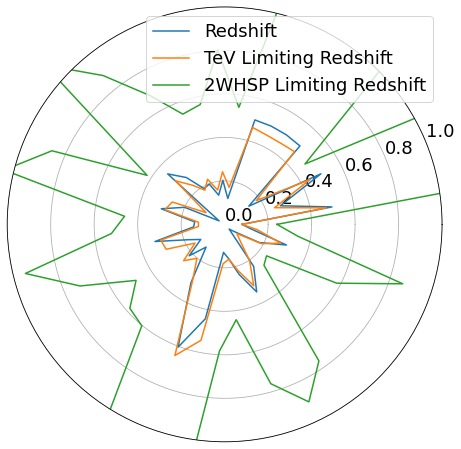

In [17]:
# Compare the limiting redshifts from the actual VERITAS observations
# to those from the selection flux limit

limiting_whsp_fluxes = np.ones(value('whsp_luminosity').size) * min_nu_f_nu
limiting_whsp_z = limiting_eflux_to_redshift(limiting_whsp_fluxes, value('whsp_luminosity'),
                                             synchrotron_peak_index)
limiting_vts_fluxes = vts_sensitivity_flux(value('exposure'))
limiting_vts_spectra, limiting_vts_bin_edges = get_spectrum(limiting_vts_fluxes, value('index'),
                                                            e_min=e_min, e_max=e_max, num_bins=num_bins)
limiting_tev_z = limiting_spectrum_to_redshift(limiting_vts_spectra, limiting_vts_bin_edges,
                                               value('deabs_luminosity'), value('index'))

min_z = np.minimum(limiting_whsp_z, limiting_tev_z)
detected = value('z') < min_z
print("{}/{} sources detected".format(sum(detected), len(min_z)))
                               
zs = {
    "Redshift": value('z'),
    "TeV Limiting Redshift": limiting_tev_z,
    "2WHSP Limiting Redshift": limiting_whsp_z
}

ax = plt.subplot(111, polar=True)
for label, arr in zs.items():
    print("{}: {}".format(label, arr))
    polar_x = (2*np.pi / arr.size)*np.arange(arr.size + 1)
    ax.plot(polar_x, np.append(arr, arr[0]), label=label)
ax.set_xticks([])
ax.set_yticks(np.arange(0, 1.1, step=0.2))
ax.set_ylim((0, 1.0))
ax.legend()

In [18]:
# Define LF functional forms to test different models, following a simplified version of Ajello et al. (2014)
# The following simplifications are made:
#   Omit dependence on the spectral index 
#   Use a single power law corresponding to the lower-luminosity region instead of a smoothly broken power law
#   Test only PLE and PDE models, not LDDE


@njit
def lf_smoothly_broken_pl_base(log10_L, *args):
    log_A, log_index_1, log_L_break, log_index_2 = args
    A, L_break, index_1, index_2 = np.exp(log_A), np.exp(log_L_break), np.exp(log_index_1), np.exp(log_index_2)
    L = 10**(log10_L - 46)
    return A / np.log(10) / L / ((L/L_break)**index_1 + (L/L_break)**index_2)


@njit
def lf_pl_base(log10_L, *args):
    log_A, log_index = args
    A, index = np.exp(log_A), np.exp(log_index)
    L = 10**(log10_L - 46)
    return A / np.log(10) * np.power(L, -index - 1)


def evolution_factor_factory(use_tau):
        
    @njit
    def evolution_factor(log10_L, z, *args):
        xi = args[1]
        if use_tau:
            k_term = args[0] + args[2]*(log10_L - 46)
        else:
            k_term = args[0]
        return np.power(1 + z, k_term) * np.exp(z/xi)
    
    return evolution_factor


def model_factory(base, evolution, use_tau):
    
    bases = {
        'power_law': (lf_pl_base, 2),
        'smoothly_broken_power_law': (lf_smoothly_broken_pl_base, 4),
    }
    base_fn, num_base_args = bases[base]
    evolution_factor = evolution_factor_factory(use_tau)
    
    def model(log10_L, z, *args):
        base_args, evolution_args = args[:num_base_args], args[num_base_args:]
        if evolution == "pde":  # pure density evolution
            return base_fn(log10_L, *base_args) * evolution_factor(log10_L, z, *evolution_args)
        elif evolution == "ple":  # pure luminosity evolution
            return base_fn(log10_L - np.log10(evolution_factor(log10_L, z, *evolution_args)), *base_args)
        else:
            raise ValueError("unknown evolution {}".format(evolution))
        
    return model

In [19]:
# Define model-independent functions used for the optimization & fitting

def detectable_volume_factory(zs, assumed_exposure, assumed_index, deabsorb=True, cutoff_exponent=10):
    """Precompute sky coverage function and comoving volume as a function of z"""
    assumed_limiting_flux = vts_sensitivity_flux(assumed_exposure)
    limiting_spectrum, limiting_bin_edges = get_spectrum(assumed_limiting_flux, assumed_index, e_min=e_min,
                                                         e_max=u.TeV/(3*zs))
    limiting_luminosities = spectrum_to_luminosity(limiting_spectrum, limiting_bin_edges, assumed_index, zs,
                                                   deabsorb=deabsorb).value
    np.nan_to_num(limiting_luminosities, nan=np.inf, copy=False)
    comoving_volumes = cosmo.differential_comoving_volume(zs).value
    
    @njit
    def detectable_volume(L, z):
        limiting_luminosity = np.interp(z, zs, limiting_luminosities)
        sky_coverage = sky_coverage_const / (1 + (limiting_luminosity/L)**cutoff_exponent)
        comoving_volume = np.interp(z, zs, comoving_volumes)
        return 4*np.pi * sky_coverage * comoving_volume
    
    return detectable_volume


def poisson_lambda(log10_L, z, model, detectable_volume, *args):
    a = model(log10_L, z, *args)
    b = detectable_volume(10**log10_L, z)
    return a * b
    return model(log10_L, z, *args) * detectable_volume(10**log10_L, z)


@njit
def neg_log_prior(args, arg_limits):
    for arg, limits in zip(args, arg_limits):
        if not limits[0] < arg < limits[1]:
            return np.inf
    return 0


def neg_log_likelihood_factory(model, assumed_exposure, assumed_index, ranges, arg_limits):
        
    limiting_zs = np.logspace(-2, 0, 400)
    detectable_volume = detectable_volume_factory(limiting_zs, assumed_exposure, assumed_index)
    
    def neg_log_likelihood(args, log10_Ls, zs):
        poisson_lambda_args = (model, detectable_volume) + tuple(args)
        term_1 = -2*np.sum(np.log(model(log10_Ls, zs, *args) * cosmo.differential_comoving_volume(zs).value))
        term_2 = 2*integrate.nquad(poisson_lambda, ranges, args=poisson_lambda_args, opts={'epsabs': np.inf})[0]
        lp = neg_log_prior(args, arg_limits)
        return np.nan_to_num(lp + term_1 + term_2, nan=np.inf)
                
    return neg_log_likelihood

In [20]:
# To construct the sky coverage, need to assume a standard spectral index (since the dependence was omitted)
# and constant exposure for every source
# Future work could derive from VERITAS observations an exposure probability distribution as a function of L, z
args = (np.log10(value('deabs_luminosity').value[detected]), value('z').value[detected])
assumed_index = np.array(3.5).reshape(1)
integration_ranges = tuple((np.min(arg), np.max(arg)) for arg in args)

# Parameter name, initial value, transform to apply, corresponding reverse transform
Param = namedtuple('Param', ['name', 'unit', 'initial_value', 'limits', 'forward_transform', 'reverse_transform'])
pl_params = [Param('A', u.Mpc**-3 * u.s/u.erg, 1e-12, (0, 1), np.log, np.exp),
             Param('alpha', u.dimensionless_unscaled, 2, (0.001, 10), np.log, np.exp)]
smoothly_broken_pl_params = [Param('L_break', u.erg/u.s, 1e47, (1e40, 1e50), lambda x: np.log(x / 1e46),
                                   lambda x: 1e46*np.exp(x)),
                             Param('beta', u.dimensionless_unscaled, 2, (0.001, 10), np.log, np.exp)]
evolution_params = [Param('k', u.dimensionless_unscaled, 10, (-100, 100), lambda x: x, lambda x: x),
                    Param('xi', u.dimensionless_unscaled, -0.2, (-10, 10), lambda x: x, lambda x :x)]
tau_param = Param('tau', u.dimensionless_unscaled, 2, (-100, 100), lambda x: x, lambda x: x)


def define_params(base, use_tau):
    base_params = {
        'power_law': pl_params,
        'smoothly_broken_power_law': pl_params + smoothly_broken_pl_params,
    }
    params = base_params[base] + evolution_params
    if use_tau:
        params.append(tau_param)
    return params

In [21]:
# Specify the model and fit it using maximum likelihood optimization

base = "power_law"
evolution = "ple"
use_tau = True

params = define_params(base, use_tau)
initial_params = tuple(param.forward_transform(param.initial_value) for param in params)
param_limits = np.array([param.forward_transform(param.limits) for param in params])
model = model_factory(base, evolution, use_tau)

neg_log_likelihood = neg_log_likelihood_factory(model, mean_exposure, assumed_index, integration_ranges,
                                                param_limits)
res = optimize.minimize(neg_log_likelihood, initial_params, args=args, method='Powell')
best_fit_params = {param.name: param.reverse_transform(final_val) for param, final_val in zip(params, res.x)}

print("Base model: {}".format(base))
print("Evolution model: {}".format(evolution))
print("Tau parameter: {}".format(use_tau))

print(res)
print("\nLog likelihood: {:.05}".format(res.fun))
for name, best_fit_val in best_fit_params.items():
    print("{}: {:.05}".format(name, best_fit_val))
print("")

<ipython-input-21-bbd29f1cd0b0>:9: RuntimeWarning: divide by zero encountered in log
  param_limits = np.array([param.forward_transform(param.limits) for param in params])
<ipython-input-11-d6091ba4c4b8>:51: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Base model: power_law
Evolution model: ple
Tau parameter: True
   direc: array([[-4.20529996e-01, -1.67490999e-01,  1.40712783e+00,
        -4.70838861e-04, -1.42439535e+00],
       [ 3.55492770e-01, -3.27446691e-01,  3.54793680e+00,
         3.70767957e-03,  5.03340449e-04],
       [ 3.13603153e-01, -1.11007420e-01,  1.28792536e+00,
         2.66560873e-03,  5.27661828e-01],
       [ 6.27009269e-01, -1.27921948e-01,  1.65150903e+00,
         4.50319075e-03,  4.92212886e-01],
       [ 1.05408509e-01, -2.45306864e-01,  2.54873076e+00,
         1.55196012e-03, -2.75769234e-01]])
     fun: -42.47858959493224
 message: 'Optimization terminated successfully.'
    nfev: 1587
     nit: 25
  status: 0
 success: True
       x: array([-2.09209386e+01, -2.15566767e+00,  4.71875320e+01, -2.59013405e-02,
        4.18536202e+00])

Log likelihood: -42.479
A: 8.2064e-10
alpha: 0.11583
k: 47.188
xi: -0.025901
tau: 4.1854



<ipython-input-11-d6091ba4c4b8>:51: RuntimeWarning: overflow encountered in exp
  return spectrum * np.exp(tau.opt_depth(z, bin_ctrs))
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


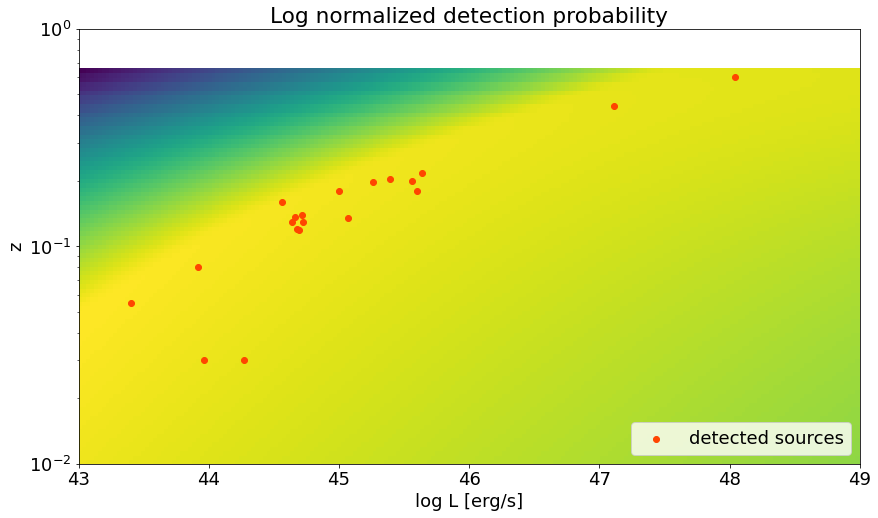

In [22]:
log10_Ls = np.linspace(43, 49, 200)
zs = np.logspace(-2, 0, 100)
ll, zz = np.meshgrid(log10_Ls, zs)

limiting_zs = np.logspace(-2, 0, 200)
detectable_volume = detectable_volume_factory(limiting_zs, mean_exposure, assumed_index)
poisson_lambdas = poisson_lambda(ll.flatten(), zz.flatten(), model, detectable_volume, *res.x)
poisson_lambdas = poisson_lambdas.reshape(ll.shape)

plt.pcolormesh(log10_Ls, zs, poisson_lambdas, norm=mpl.colors.LogNorm())
plt.title("Log normalized detection probability")
plt.xlabel("log L [erg/s]")
plt.yscale('log')
plt.ylabel("z")
plt.scatter(*args, color='orangered', label="detected sources")
plt.legend(loc="lower right")

In [23]:
# Estimate the errors on the model parameters using Monte Carlo simulations

# Initialize the walkers around the ML best fit
ndim, nwalkers = len(res.x), 20
p0 = res.x + 1e-4 * np.random.randn(nwalkers, ndim)

def log_likelihood(args, log10_Ls, zs):
    return -neg_log_likelihood(args, log10_Ls, zs)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=args)

sampler.run_mcmc(p0, 5000)

<ipython-input-19-22710a787455>:48: RuntimeWarning: invalid value encountered in double_scalars
  return np.nan_to_num(lp + term_1 + term_2, nan=np.inf)
<ipython-input-18-7591a3d5451b>:52: RuntimeWarning: divide by zero encountered in log10
  return base_fn(log10_L - np.log10(evolution_factor(log10_L, z, *evolution_args)), *base_args)
<ipython-input-19-22710a787455>:45: RuntimeWarning: divide by zero encountered in log
  term_1 = -2*np.sum(np.log(model(log10_Ls, zs, *args) * cosmo.differential_comoving_volume(zs).value))
/home/aribrill/software/anaconda3/envs/sci/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling th

State([[-2.04983500e+01 -4.43163165e+00  7.36101336e-01  6.73587999e-01
   1.88178420e+00]
 [-1.97773037e+01 -6.22299730e+00 -2.69047960e+00 -9.74569932e+00
   3.51496777e+00]
 [-1.97286285e+01 -4.93406969e+00 -1.17682685e+00 -8.55227792e+00
   3.07989800e+00]
 [-2.03198578e+01 -6.45034034e+00  7.40942169e-01 -6.26803582e+00
   2.38279639e+00]
 [-2.07509034e+01 -6.01130768e+00  3.43152446e+00  8.06246768e+00
   1.14897099e+00]
 [-2.01790138e+01 -2.77605280e+00  8.31300623e-02  7.69232896e+00
   1.72289973e+00]
 [-2.04685305e+01 -2.56577929e+00  4.65284408e-01 -8.02420087e-01
   4.53295639e+00]
 [-2.01340283e+01 -5.80621464e+00 -6.63362023e-01 -9.61408557e+00
   2.08082863e+00]
 [-2.07667949e+01 -5.08679845e+00  3.83008894e+01 -3.29529843e-02
   2.67651350e+00]
 [-2.02452876e+01 -4.42122936e+00  1.77121023e+01 -6.33486777e-02
   4.99110896e+00]
 [-2.12695336e+01 -5.10830265e+00  5.55196305e+00  1.08839814e+00
   5.67144854e-01]
 [-2.00192576e+01 -3.39090146e+00 -1.61368058e+00 -5.852579

N/50 = 100;
tau: [226.03737391 219.29306373 603.40959515 214.68946811 241.79705272]


Mean acceptance fraction: 0.308
Mean autocorrelation time: 301.045 steps


Text(0.5, 0, 'step number')

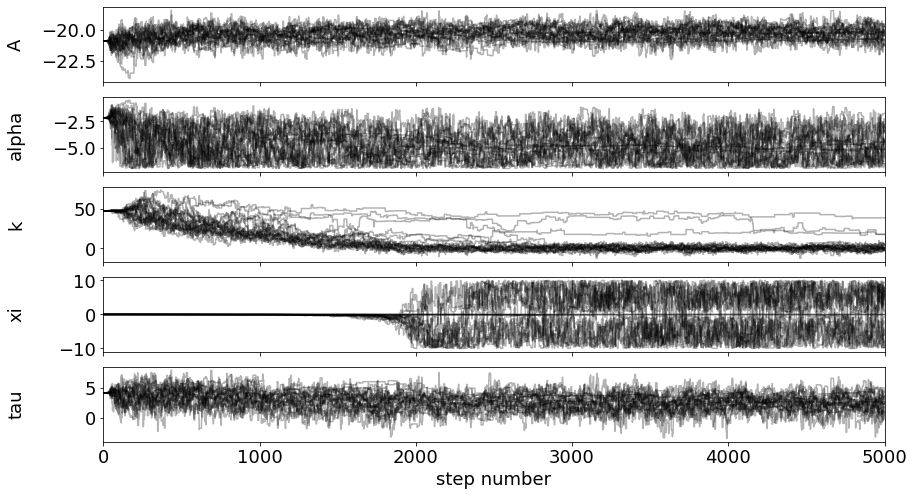

In [24]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print("Mean autocorrelation time: {0:.3f} steps".format(np.mean(sampler.get_autocorr_time(quiet=True))))

all_samples = sampler.get_chain()

fig, axes = plt.subplots(ndim, sharex=True)
labels = [param.name for param in params]
for i, ax in enumerate(axes):
    ax.plot(all_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(all_samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [25]:
flat_samples = sampler.get_chain(discard=4000, flat=True)
plot_samples = np.zeros(flat_samples.shape)
for i, param in enumerate(params):
    plot_samples[:, i] = param.reverse_transform(flat_samples[:, i])

A = -20.27 + 0.5397 - 0.4809
alpha = -5.064 + 1.227 - 1.502
k = 0.8494 + 2.889 - 6.315
xi = -0.05183 + 6.316 - 6.823
tau = 2.562 + 1.206 - 1.238


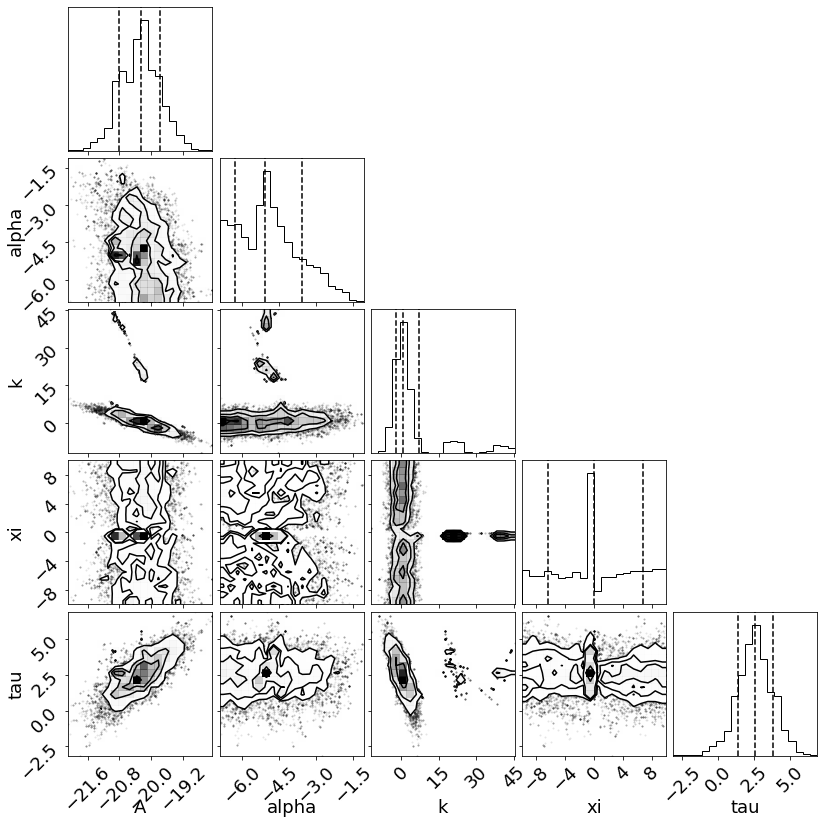

In [26]:
fig = corner.corner(flat_samples, quantiles=[0.16, 0.5, 0.84], labels=labels)

for i, label in enumerate(labels):
    lower, median, upper = np.percentile(flat_samples[:, i], [16, 50, 84])
    lower_err, upper_err = np.diff((lower, median, upper))
    print("{} = {:.04} + {:.04} - {:.04}".format(label, median, lower_err, upper_err))

<V/V_max> = 0.532 +- 0.065


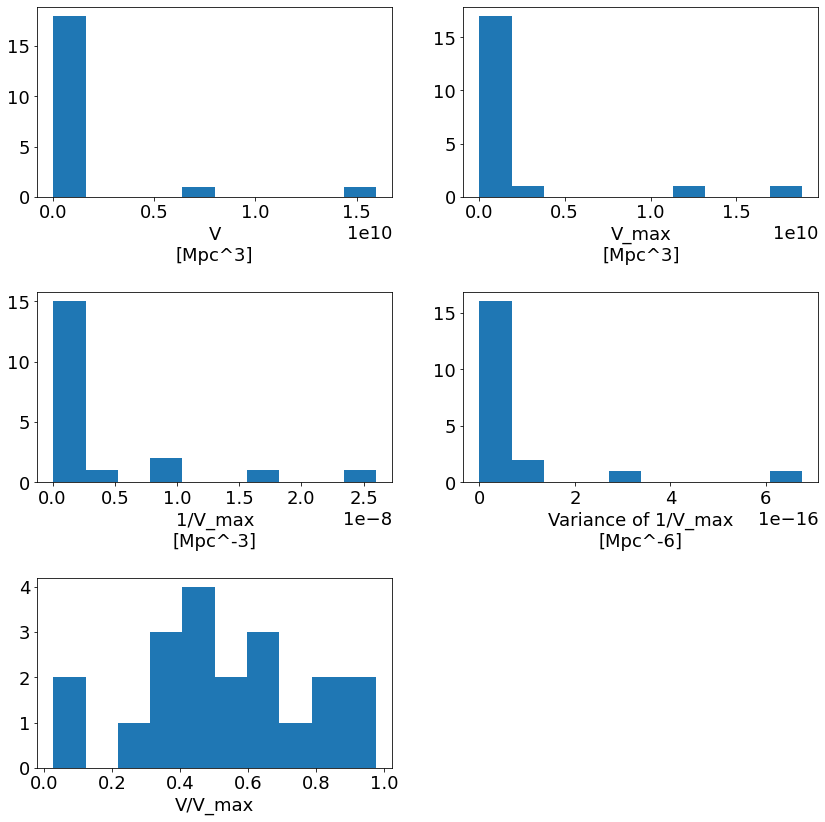

In [27]:
# Calculate V and V_max for each detected source,
# and perform a model-independent test for evolution using the V/V_max test

v = cosmo.comoving_volume(value('z').value[detected]) * sky_coverage_const
v_max = cosmo.comoving_volume(min_z.value[detected]) * sky_coverage_const
inverse_v_max = 1 / v_max
inverse_v_max_var = 1 / v_max**2
v_over_v_max = v / v_max

volumes = {
    "V\n[Mpc^3]": v,
    "V_max\n[Mpc^3]": v_max,
    "1/V_max\n[Mpc^-3]": inverse_v_max,
    "Variance of 1/V_max\n[Mpc^-6]": inverse_v_max_var,
    "V/V_max": v_over_v_max,
}

print("<V/V_max> = {:.3f} +- {:.3f}".format(np.mean(v_over_v_max), np.sqrt(1/(12*sum(detected)))))

fig, axes = plt.subplots(3, 2, figsize=(14.0, 14.0))
for ax, (label, arr) in zip(axes.ravel(), volumes.items()):
    ax.hist(arr.value)
    ax.set_xlabel(label)
axes[-1, -1].set_axis_off()
plt.subplots_adjust(hspace=0.5)

In [28]:
# Calculate density-weighted V_max to account for evolution 

def weighted_v_max(z_max, log10_L, evolution_args, evolution_factor, z_min=0):
        
    def integrand(z, *args):
        log10_L, z_min, *evolution_args = args
        norm = evolution_factor(log10_L, z_min, *evolution_args)
        return detectable_volume(10**log10_L, z) * evolution_factor(log10_L, z, *evolution_args) / norm
    
    v_max = integrate.quad(integrand, z_min, z_max, args=tuple([log10_L, z_min, *evolution_args]),
                           epsabs=np.inf)[0]
    return v_max

weight_args = [min_z.value[detected], np.log10(value('deabs_luminosity').value[detected])]
num_evolution_params = len(evolution_params) + int(use_tau)
evolution_factor = evolution_factor_factory(use_tau)
weighted_v_maxes = np.array([weighted_v_max(z_max, log10_L, res.x[-num_evolution_params:], evolution_factor)
                             for z_max, log10_L in zip(*weight_args)])*u.Mpc**3
weighted_densities = 1 / weighted_v_maxes

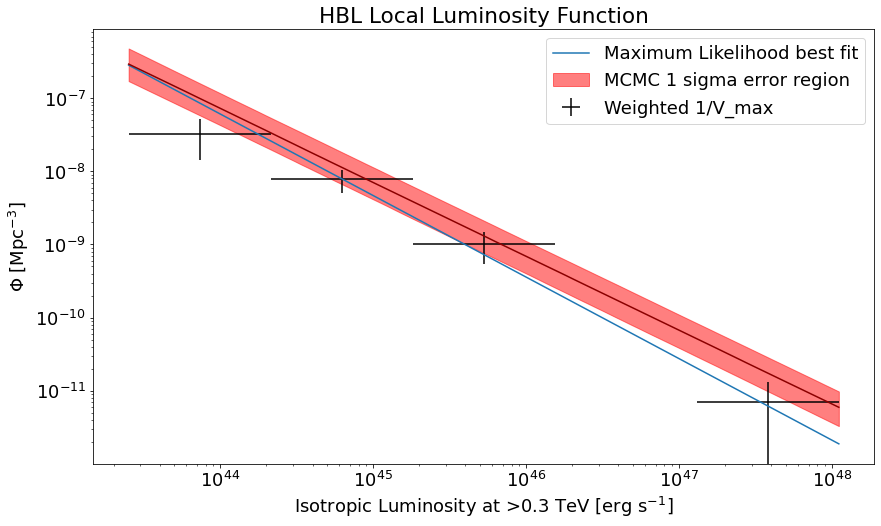

In [29]:
def plot_lf_v_max(luminosities, densities, label=None):
    lum_bins = 10**np.linspace(*integration_ranges[0], 6)
    bin_idxs = np.digitize(luminosities.value, lum_bins) - 1
    x, xerr, y, yerr = [], [], [], []
    for i, lum_bin in enumerate(lum_bins[:-1]):
        bin_center = stats.gmean(lum_bins[i:i+2])
        bin_size = np.log(lum_bins[i + 1]) - np.log(lum_bins[i])
        x.append(bin_center)
        xerr.append((bin_center - lum_bins[i], lum_bins[i + 1] - bin_center))
        y.append(np.sum(densities[bin_idxs == i].value) / bin_size)
        yerr.append(np.sqrt(np.sum(densities[bin_idxs == i].value**2)) / bin_size)
    x, y, xerr, yerr = np.array(x), np.array(y), np.array(xerr).T, np.array(yerr)
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, label=label, linestyle='none', color='k')

    
def plot_lf_ml(luminosities, model, best_fit_params, label=None):
    plt.plot(luminosities, model(np.log10(luminosities), 0, *best_fit_params), label=label)
    

def plot_mcmc(luminosities, model, samples, label=None):
    curves = []
    for sample in samples:
        curves.append(model(np.log10(luminosities), 0, *sample))

    # Plot 95% confidence interval
    lo, med, hi = np.percentile(curves, (16, 50, 84), axis=0)
    plt.plot(luminosities, med, color='darkred')
    plt.fill_between(luminosities, lo, hi, color='red', alpha=0.5, label=label)

    

plot_lf_v_max(value('deabs_luminosity')[detected], weighted_densities, label="Weighted 1/V_max")
luminosities = 10**np.linspace(*integration_ranges[0], 100)
plot_lf_ml(luminosities, model, res.x, label="Maximum Likelihood best fit")
plot_mcmc(luminosities, model, flat_samples, label="MCMC 1 sigma error region")

plt.title("HBL Local Luminosity Function")
plt.xscale('log')
plt.xlabel("Isotropic Luminosity at >{} TeV".format(e_min.to_value(u.TeV)) + " [erg s$^{-1}$]")
plt.yscale('log')
plt.ylabel("$\Phi$ [Mpc$^{-3}$]")
plt.legend()